In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import requests

# Gathering the data

In [3]:
#### Reading twitter archive enhanced file ####
df_twitter_archive=pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [4]:
### Requesting image predictions from URL ###
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
req = requests.get(url, allow_redirects=True)
file_name = url.rsplit('/', 1)[1]
with open(file_name,'wb') as f:
    for chunk in req.iter_content(chunk_size=800):
        if chunk:
            f.write(chunk)
            

In [5]:
df_images=pd.read_table('image-predictions.tsv')
df_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [215]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

NameError: name 'df_1' is not defined

In [6]:
empty_lst = []
with open('tweet-json.txt') as json_file:
    for line in json_file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        empty_lst.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
df_api = pd.DataFrame(empty_lst)

In [7]:
df_api

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [8]:
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1412,698953797952008193,NaN,NaN,2016-02-14 19:35:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet CeCe. She wanted to take a selfie before ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698953797...,11,10,CeCe,None,None,None,None
1934,674014384960745472,NaN,NaN,2015-12-07 23:55:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Aiden. His eyes are magical. Love...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674014384...,11,10,Aiden,None,None,None,None
1720,680145970311643136,NaN,NaN,2015-12-24 22:00:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Kawhi. He was doing fine until hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680145970...,10,10,Kawhi,None,None,pupper,None
2108,670452855871037440,NaN,NaN,2015-11-28 04:03:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog can't see its haters. 11/10 https://t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670452855...,11,10,None,None,None,None,None
1263,710117014656950272,NaN,NaN,2016-03-16 14:54:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper got her hair chalked for her birth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710117014...,11,10,None,None,None,pupper,None
153,862457590147678208,NaN,NaN,2017-05-11 00:01:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Jersey. He likes to watch movies, but ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/862457590...,13,10,Jersey,None,None,None,None
1251,710997087345876993,NaN,NaN,2016-03-19 01:11:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Milo and Amos. They are the best of pals....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710997087...,12,10,Milo,None,None,None,None
50,882627270321602560,NaN,NaN,2017-07-05 15:48:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stanley. He has his first swim lesson ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882627270...,13,10,Stanley,None,None,None,None
1355,703611486317502464,NaN,NaN,2016-02-27 16:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Scooter. He's experiencing the pupper equ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703611486...,10,10,Scooter,None,None,pupper,None
129,867421006826221569,NaN,NaN,2017-05-24 16:44:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shikha. She just watched you drop a sk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/867421006...,12,10,Shikha,None,None,None,puppo


- Missing Values of Calssifications Like doggo, floofer, pupper, puppo
- The missing values are written as none and not NaN
- There are four columns and it should be only one named classification 

In [9]:
df_twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
            ... 
Dudley         1
Vince          1
Zuzu           1
Bobb           1
Bookstore      1
Name: name, Length: 957, dtype: int64

- Wrong names like the name a
- None values for names 

In [10]:
df_twitter_archive.rating_numerator

0       13
1       13
2       12
3       13
4       12
        ..
2351     5
2352     6
2353     9
2354     7
2355     8
Name: rating_numerator, Length: 2356, dtype: int64

- Some rating numerators are below 10

In [11]:
df_twitter_archive['rating_numerator'][df_twitter_archive['rating_numerator']>20].value_counts

<bound method IndexOpsMixin.value_counts of 188      420
189      666
290      182
313      960
340       75
433       84
516       24
695       75
763       27
902      165
979     1776
1120     204
1202      50
1228      99
1254      80
1274      45
1351      60
1433      44
1634     143
1635     121
1712      26
1779     144
1843      88
2074     420
Name: rating_numerator, dtype: int64>

- some ratings are very large

In [12]:
df_twitter_archive[df_twitter_archive['rating_numerator']<10].sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1134,728653952833728512,NaN,NaN,2016-05-06 18:33:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Coleman. Somebody needs to tell him th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728653952...,8,10,Coleman,None,None,None,None


In [13]:
df_twitter_archive.text.iloc[2233]

"This is Ron. Ron's currently experiencing a brain freeze. Damn it Ron. 8/10 https://t.co/4ilfcR5SlK"

In [14]:
df_twitter_archive[df_twitter_archive['rating_denominator']!=10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


- some rating denominators does not equal 10 

In [15]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

- Three ids like twiteer id should be strings.
- Dogs classifications like doggo and floofer should be catogeries. 

In [16]:
### Studying the seconnd dataframe ###
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


# Assissing For first dataframe:
## Quality Issues:
- Missing Values of Calssifications Like doggo, floofer, pupper, puppo.
- The missing values are written as none and not NaN.
- Wrong names like the name a.
- None values for names.
- Some rating numerators are Wrong, some are very large and some are below 10.
- Three ids like twiteer id should be strings.
- Dogs classifications like doggo and floofer should be categories.
- some rating denominators does not equal 10.
- data with no images should be deleted (Expanded URL = NaN)
- Deleting the rows that retweets and replies have values in it.*
- Deleting columns of retweets and replies and source and expanded url.
## Tideness Issues:
- There are four columns and it should be only one named classification.
- merge three dataframes into one.

# Cleaning

In [17]:
### Taking copies of the dataframes ###
df_twitter_archive_clean=df_twitter_archive.copy()
df_images_clean= df_images.copy()
df_api_clean= df_api.copy()

##### Define
- Delet the IDs that are in first dataframe and not in second one 

##### Code

In [18]:
df_twitter_archive_clean= df_twitter_archive_clean[df_twitter_archive_clean.tweet_id.isin(df_images.tweet_id)]

In [19]:
df_twitter_archive_clean.shape[0]

2075

##### Define
- Scrap missing names from text if not there make it as NaN

###### Code
- using regular expressions.

In [20]:
pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in df_twitter_archive_clean.iterrows():  
    if row['name'][0].islower() or row['name'] == 'None':
        try:
            c_name = re.findall(pattern, row['text'])[0]
            df_twitter_archive_clean.loc[index,'name'] = df_twitter_archive_clean.loc[index,'name'].replace(row['name'], c_name)

        except IndexError:
            df_twitter_archive_clean.loc[index,'name'] = np.nan

##### Test

In [21]:
df_twitter_archive_clean.name.value_counts()

Charlie      11
Penny        10
Lucy         10
Cooper       10
Tucker       10
             ..
Jebberson     1
Moofasa       1
Dudley        1
Kip           1
Bookstore     1
Name: name, Length: 938, dtype: int64

##### Define
- Delet rows that has values in retweeted_status_id	columns
- Delet rows that has no values in expanded_urls.

##### Code

In [22]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['expanded_urls'].notnull()]

##### Test

In [23]:
df_twitter_archive_clean['expanded_urls'].isnull().sum()

0

##### Define
- Delet the rows that have values in retweeted_status_id column.
- Delet the rows that have values in in_reply_to_status_id column.

##### Code

In [24]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['retweeted_status_id'].isnull()]
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['in_reply_to_status_id'].isnull()]

##### Test

In [25]:
df_twitter_archive_clean['retweeted_status_id'].count()

0

In [26]:
df_twitter_archive_clean['in_reply_to_status_id'].count()

0

In [27]:
df_twitter_archive_clean.shape[0]

1971

##### Define
- Drop Columns that are no longer needed like retweets ids.

##### Code

In [28]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id'
                                   ,'retweeted_status_user_id','retweeted_status_timestamp', 'source', 'expanded_urls'],axis=1)

##### Test

In [29]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


##### Define
- Replace all None Values in the Doggo, floofer ,.. columns with empty charachter
- make all columns as one column called dog_class
- replace all empty charachter with NaN values

In [30]:
# replace None with ""
df_twitter_archive_clean['doggo'] = df_twitter_archive_clean['doggo'].replace('None','')
df_twitter_archive_clean['floofer'] = df_twitter_archive_clean['floofer'].replace('None','')
df_twitter_archive_clean['pupper'] = df_twitter_archive_clean['pupper'].replace('None','')
df_twitter_archive_clean['puppo'] = df_twitter_archive_clean['puppo'].replace('None','')

# Concatenate 4 columns into one column
df_twitter_archive_clean['dog_class'] = df_twitter_archive_clean['doggo'] + df_twitter_archive_clean['floofer'] + df_twitter_archive_clean['pupper'] + df_twitter_archive_clean['puppo']

# replace "" with NaN
df_twitter_archive_clean['dog_class'] = df_twitter_archive_clean['dog_class'].replace('', np.nan)

# drop (doggo, floofer, pupper, puppo) columns
columns_list = ['doggo', 'floofer', 'pupper', 'puppo']
df_twitter_archive_clean.drop(columns_list, inplace=True, axis=1)

##### Test

In [31]:
df_twitter_archive_clean.sample(7)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_class
1853,675706639471788032,2015-12-12 15:59:51 +0000,This is a Sizzlin Menorah spaniel from Brookly...,10,10,Wylie,NaN
2292,667160273090932737,2015-11-19 01:59:39 +0000,This is Bradlay. He is a Ronaldinho Matsuyama ...,11,10,Bradlay,NaN
1436,697255105972801536,2016-02-10 03:05:46 +0000,Meet Charlie. He likes to kiss all the big mil...,10,10,Charlie,NaN
2154,669625907762618368,2015-11-25 21:17:12 +0000,This is Penny. She's having fun AND being safe...,12,10,Penny,NaN
1958,673580926094458881,2015-12-06 19:13:01 +0000,When you ask your professor about extra credit...,8,10,NaN,NaN
2072,671109016219725825,2015-11-29 23:30:32 +0000,This is Toby. He asked for chocolate cake for ...,8,10,Toby,NaN
1128,729823566028484608,2016-05-10 00:01:12 +0000,This is Stefan. He's a downright remarkable pu...,13,10,Stefan,NaN


In [32]:
#### Reseting indexis
df_twitter_archive_clean.reset_index(drop=True, inplace=True)

In [33]:
df_twitter_archive_clean['dog_class'].value_counts()

pupper          201
doggo            63
puppo            22
doggopupper       8
floofer           7
doggopuppo        1
doggofloofer      1
Name: dog_class, dtype: int64

##### Define
- sperate the classes with space

##### Code

In [34]:
for i in range (1971):
    if df_twitter_archive_clean['dog_class'][i]=='doggopupper':
        df_twitter_archive_clean['dog_class'][i] = 'doggo pupper'
        
    if df_twitter_archive_clean['dog_class'][i]=='doggopuppo':
        df_twitter_archive_clean['dog_class'][i] = 'doggo puppo'
        
    if df_twitter_archive_clean['dog_class'][i]=='doggofloofer':
        df_twitter_archive_clean['dog_class'][i] = 'doggo floofer'

<ipython-input-34-35ac1b7d8697>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter_archive_clean['dog_class'][i] = 'doggo puppo'
<ipython-input-34-35ac1b7d8697>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter_archive_clean['dog_class'][i] = 'doggo floofer'
<ipython-input-34-35ac1b7d8697>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter_archive_clean['dog_class'][i] = 'doggo pupper'


##### Test

In [35]:
df_twitter_archive_clean['dog_class'].value_counts()

pupper           201
doggo             63
puppo             22
doggo pupper       8
floofer            7
doggo puppo        1
doggo floofer      1
Name: dog_class, dtype: int64

##### Define
- convert the ratings to float
- get the number of dogs
- claculate the average

In [36]:
# converting to float
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].astype(float)

# scrap the text for the right numerator rating value
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['text'].str.extract('(\d+\.?\d?\d?)\/\d{1,3}', expand = False).astype('float')

# getting num of dogs for big values of numerator & denominator
df_twitter_archive_clean['dogs_num'] = df_twitter_archive_clean['rating_denominator'][df_twitter_archive_clean['rating_denominator'] >= 20]/10

In [37]:
df_twitter_archive_clean.dogs_num.value_counts()

5.0     3
8.0     2
12.0    1
11.0    1
4.0     1
9.0     1
2.0     1
17.0    1
15.0    1
7.0     1
Name: dogs_num, dtype: int64

In [38]:
##### Calculating the average of the rating_numerator
df_twitter_archive_clean['rating_numerator'][df_twitter_archive_clean['rating_numerator'] >= 20] = df_twitter_archive_clean['rating_numerator'][df_twitter_archive_clean['rating_numerator'] >= 20]/df_twitter_archive_clean['dogs_num'][df_twitter_archive_clean['dogs_num']>0]

<ipython-input-38-52dc10b437ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter_archive_clean['rating_numerator'][df_twitter_archive_clean['rating_numerator'] >= 20] = df_twitter_archive_clean['rating_numerator'][df_twitter_archive_clean['rating_numerator'] >= 20]/df_twitter_archive_clean['dogs_num'][df_twitter_archive_clean['dogs_num']>0]


##### Test

In [39]:
df_twitter_archive_clean['rating_numerator'].value_counts()

12.00    450
10.00    419
11.00    397
13.00    253
9.00     151
8.00      95
7.00      52
14.00     33
6.00      32
5.00      32
3.00      19
4.00      16
2.00       9
1.00       5
9.75       1
0.00       1
11.26      1
13.50      1
11.27      1
Name: rating_numerator, dtype: int64

##### Define
- Make all denominators =10

##### Code

In [40]:
df_twitter_archive_clean['rating_denominator'][df_twitter_archive_clean['rating_denominator'] != 10]=10

<ipython-input-40-989126db1d2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter_archive_clean['rating_denominator'][df_twitter_archive_clean['rating_denominator'] != 10]=10


###### Test

In [41]:
df_twitter_archive_clean['rating_denominator'].value_counts()

10    1971
Name: rating_denominator, dtype: int64

In [42]:
df_twitter_archive_clean.sample(7)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_class,dogs_num
780,742465774154047488,2016-06-13 21:16:49 +0000,Was just informed about this hero pupper and o...,14.0,10,NaN,pupper,NaN
1083,700029284593901568,2016-02-17 18:49:22 +0000,This is Coops. His ship is taking on water. So...,10.0,10,Coops,NaN,NaN
1859,667915453470232577,2015-11-21 04:00:28 +0000,Meet Otis. He is a Peruvian Quartzite. Pic spo...,10.0,10,Otis,NaN,NaN
1256,686358356425093120,2016-01-11 01:25:58 +0000,Heartwarming scene here. Son reuniting w fathe...,10.0,10,NaN,NaN,NaN
876,724405726123311104,2016-04-25 01:12:38 +0000,This is Ashleigh. She's having Coachella withd...,10.0,10,Ashleigh,pupper,NaN
942,713177543487135744,2016-03-25 01:35:51 +0000,This is Lance. Lance doesn't give a shit. 10/1...,10.0,10,Lance,NaN,NaN
1371,680085611152338944,2015-12-24 18:00:19 +0000,This is by far the most coordinated series of ...,12.0,10,NaN,NaN,NaN


##### Define
- Making all IDs alike in the three dataframes

##### code

In [43]:
df_api_clean= df_api_clean[df_api_clean.tweet_id.isin(df_twitter_archive_clean.tweet_id)]
df_images_clean= df_images_clean[df_images_clean.tweet_id.isin(df_twitter_archive_clean.tweet_id)]

##### Test

In [44]:
df_api_clean.shape[0]

1971

In [45]:
df_images_clean.shape[0]

1971

##### Define
- Reseting all indexis

##### Code

In [46]:
df_twitter_archive_clean = df_twitter_archive_clean.reset_index(drop=True)
df_images_clean = df_images_clean.reset_index(drop=True)
df_api_clean = df_api_clean.reset_index(drop=True)

##### Test

In [47]:
df_twitter_archive_clean.tail()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_class,dogs_num
1966,666049248165822465,2015-11-16 00:24:50 +0000,Here we have a 1949 1st generation vulpix. Enj...,5.0,10,NaN,NaN,NaN
1967,666044226329800704,2015-11-16 00:04:52 +0000,This is a purebred Piers Morgan. Loves to Netf...,6.0,10,NaN,NaN,NaN
1968,666033412701032449,2015-11-15 23:21:54 +0000,Here is a very happy pup. Big fan of well-main...,9.0,10,NaN,NaN,NaN
1969,666029285002620928,2015-11-15 23:05:30 +0000,This is a western brown Mitsubishi terrier. Up...,7.0,10,NaN,NaN,NaN
1970,666020888022790149,2015-11-15 22:32:08 +0000,Here we have a Japanese Irish Setter. Lost eye...,8.0,10,NaN,NaN,NaN


In [48]:
df_images_clean.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1966,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
1967,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
1968,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
1969,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1970,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [49]:
df_api_clean.tail()

,tweet_id,retweet_count,favorite_count
1966,666049248165822465,41,111
1967,666044226329800704,147,311
1968,666033412701032449,47,128
1969,666029285002620928,48,132
1970,666020888022790149,532,2535


##### Define 
- Merge three DFs to one big DF

In [50]:
all_df = pd.merge(df_twitter_archive_clean,df_api_clean, on ='tweet_id' , how = 'left')
all_df = pd.merge(all_df,df_images_clean, on ='tweet_id' , how = 'left')

In [51]:
all_df

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_class,dogs_num,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,NaN,8853,39467,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,NaN,6514,33819,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,NaN,4328,25461,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,NaN,8964,42908,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,NaN,9774,41048,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,666049248165822465,2015-11-16 00:24:50 +0000,Here we have a 1949 1st generation vulpix. Enj...,5.0,10,NaN,NaN,NaN,41,111,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
1967,666044226329800704,2015-11-16 00:04:52 +0000,This is a purebred Piers Morgan. Loves to Netf...,6.0,10,NaN,NaN,NaN,147,311,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
1968,666033412701032449,2015-11-15 23:21:54 +0000,Here is a very happy pup. Big fan of well-main...,9.0,10,NaN,NaN,NaN,47,128,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
1969,666029285002620928,2015-11-15 23:05:30 +0000,This is a western brown Mitsubishi terrier. Up...,7.0,10,NaN,NaN,NaN,48,132,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


##### Define 
- Convert tweet_ID to string

##### Code

In [52]:
all_df['tweet_id'] = all_df['tweet_id'].astype('str')

##### Test

In [53]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   object 
 1   timestamp           1971 non-null   object 
 2   text                1971 non-null   object 
 3   rating_numerator    1968 non-null   float64
 4   rating_denominator  1971 non-null   int64  
 5   name                1379 non-null   object 
 6   dog_class           303 non-null    object 
 7   dogs_num            13 non-null     float64
 8   retweet_count       1971 non-null   int64  
 9   favorite_count      1971 non-null   int64  
 10  jpg_url             1971 non-null   object 
 11  img_num             1971 non-null   int64  
 12  p1                  1971 non-null   object 
 13  p1_conf             1971 non-null   float64
 14  p1_dog              1971 non-null   bool   
 15  p2                  1971 non-null   object 
 16  p2_con

##### Define 
- change time to datetime

##### Code

In [54]:
all_df['timestamp'] = pd.to_datetime(all_df['timestamp'])

##### Test

In [55]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   text                1971 non-null   object             
 3   rating_numerator    1968 non-null   float64            
 4   rating_denominator  1971 non-null   int64              
 5   name                1379 non-null   object             
 6   dog_class           303 non-null    object             
 7   dogs_num            13 non-null     float64            
 8   retweet_count       1971 non-null   int64              
 9   favorite_count      1971 non-null   int64              
 10  jpg_url             1971 non-null   object             
 11  img_num             1971 non-null   int64              
 12  p1                  1971 non-null 

##### Storing Data

##### Code

In [56]:
all_df.to_csv('twitter_archive_master.csv',index=False)

In [57]:
### seeing different rows analysis
all_df.describe()

,rating_numerator,rating_denominator,dogs_num,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1968.000000,1971.0,13.000000,1971.000000,1971.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03
mean,10.534949,10.0,8.307692,2784.449518,8949.106545,1.201928,0.594558,1.345850e-01,6.016556e-02
std,2.180625,0.0,4.423133,4697.662893,12267.799790,0.559020,0.272126,1.010527e-01,5.094156e-02
min,0.000000,10.0,2.000000,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.0,5.000000,628.500000,1997.000000,1.000000,0.363091,5.339800e-02,1.608055e-02
50%,11.000000,10.0,8.000000,1367.000000,4147.000000,1.000000,0.587764,1.173970e-01,4.944380e-02
75%,12.000000,10.0,11.000000,3239.000000,11402.500000,1.000000,0.847827,1.955655e-01,9.153815e-02
max,14.000000,10.0,17.000000,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


### Insigts
- Average Ratings
- Max num of favourites
- Most Common name

In [58]:
#### Calculate the average ####
all_df.rating_numerator.mean()

10.53494918699187

In [59]:
#### Calculate the max num of favourites ####
all_df.favorite_count.max()

132810

In [60]:
#### Calculate Most Common name ####
all_df.name.mode()[0]

'Charlie'

### Plotting the relation between ratings and favourites 

Text(0.5, 1.0, 'Relation between ratings numerator and favourites ')

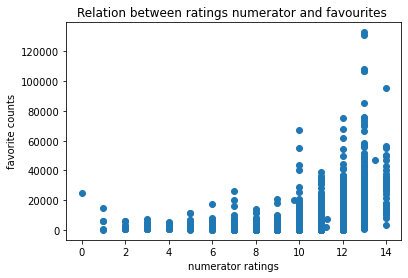

In [63]:
plt.scatter(all_df['rating_numerator'], all_df['favorite_count']);
plt.xlabel('numerator ratings');
plt.ylabel('favorite counts');
plt.title('Relation between ratings numerator and favourites ')

Text(0.5, 1.0, 'Relation between years and favourites')

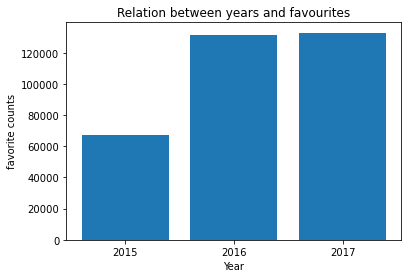

In [65]:
all_df['year']=all_df['timestamp'].dt.year
plt.bar(all_df['year'], all_df['favorite_count']);
plt.xlabel('Year');
plt.ylabel('favorite counts');
plt.xticks(range(2015,2018,1));
plt.title('Relation between years and favourites')